## 1. 라이브러리

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import warnings
warnings.filterwarnings(action='ignore')

from matplotlib import pyplot as plt
from matplotlib import rcParams
%matplotlib inline

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pathlib import Path
from collections import  Counter

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import re

## 2. 데이터 확인하기
1. train
2. test
3. sample_submission

In [2]:
# 파일 불러오기
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test_x.csv')
sample_submission = pd.read_csv('data/sample_submission.csv', encoding = 'utf-8')

In [3]:
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54879 entries, 0 to 54878
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   54879 non-null  int64 
 1   text    54879 non-null  object
 2   author  54879 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.3+ MB


,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3


In [4]:
test.info()
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19617 entries, 0 to 19616
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   19617 non-null  int64 
 1   text    19617 non-null  object
dtypes: int64(1), object(1)
memory usage: 306.6+ KB


,index,text
0,0,“Not at all. I think she is one of the most ch...
1,1,"""No,"" replied he, with sudden consciousness, ""..."
2,2,As the lady had stated her intention of scream...
3,3,“And then suddenly in the silence I heard a so...
4,4,His conviction remained unchanged. So far as I...


In [5]:
sample_submission

,index,0,1,2,3,4
0,0,0,0,0,0,0
1,1,0,0,0,0,0
2,2,0,0,0,0,0
3,3,0,0,0,0,0
4,4,0,0,0,0,0
...,...,...,...,...,...,...
19612,19612,0,0,0,0,0
19613,19613,0,0,0,0,0
19614,19614,0,0,0,0,0
19615,19615,0,0,0,0,0


## 3. 데이터 전처리
1. **클렌징**: 자연어 처리에 불필요한 부호 제거, 대문자 → 소문자 변환
2. **스톱워즈 제거**: 자연어 처리에 혼동을 줄 수 있는 stopwords 제거


**- 클렌징**

In [6]:
# 클렌징: 부호 제거, 소문자 변환
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text.lower())

train['text']=train['text'].apply(alpha_num)

In [7]:
train

,index,text,author
0,0,he was almost choking there was so much so muc...,3
1,1,your sister asked for it i suppose,2
2,2,she was engaged one day as she walked in peru...,1
3,3,the captain was in the porch keeping himself c...,4
4,4,have mercy gentlemen odin flung up his hands d...,3
...,...,...,...
54874,54874,is that you mr smith odin whispered i hardly d...,2
54875,54875,i told my plan to the captain and between us w...,4
54876,54876,your sincere wellwisher friend and sister luc...,1
54877,54877,then you wanted me to lend you money,3


- 결과
  - 문장 부호가 모두 제거, 전체 문장에 소문자만 존재
    
<br>

**- 스톱워즈 제거**

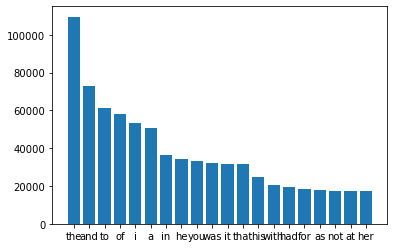

In [8]:
# 스톱워즈 제거
def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:20] 
    x,y=zip(*top)
    plt.bar(x,y)

plot_top_stopwords_barchart(train['text'])  

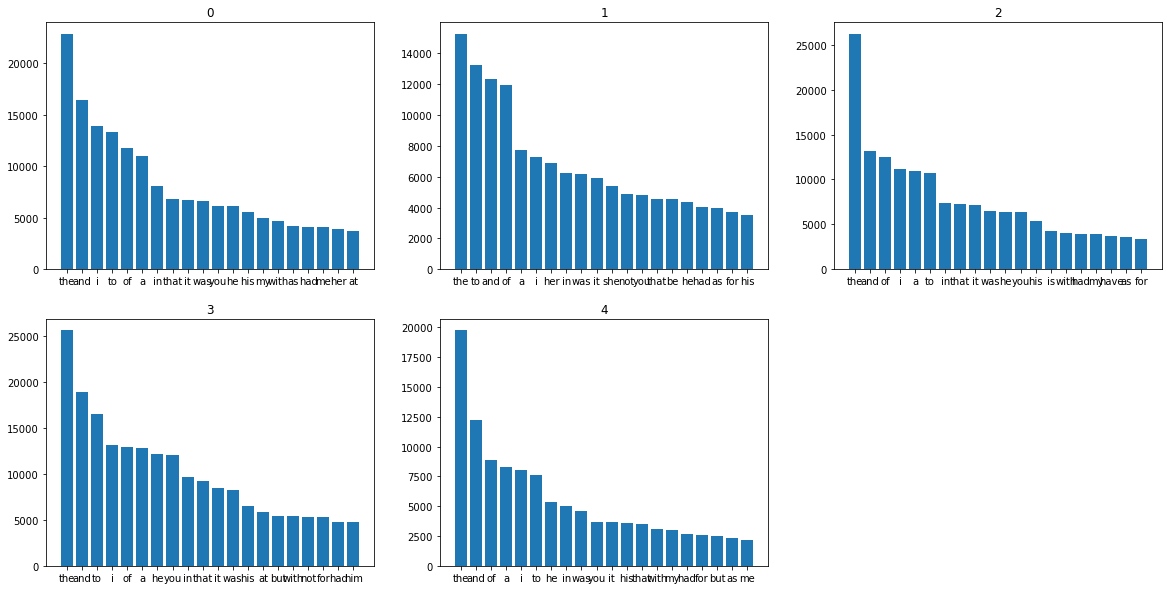

In [9]:
fig = plt.figure(figsize=(20,10)) # rows*cols 행렬의 i번째 subplot 생성
rows = 2
cols = 3
i = 1

def plot_top_stopwords_barchart2(text):
    stop=set(stopwords.words('english'))
    
    new = text.str.split()
    new = new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:20] 
    x,y=zip(*top)
    return x, y

for i in range(5):
    x,y = plot_top_stopwords_barchart2(train[train['author']==i]['text'])
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(i)
    ax.bar(x,y)

- 결과
  - 제거할 stopwords 선정: the, and, i, to, of, a, in, to, had, he, that, you, was, with, form, his, as, odin, said, one

In [85]:
# 스톱워즈 제거 함수
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

# 스톱워즈
stopwords = ['the', 'and', 'i', 'to', 'of', 'a', 'in', 'to', 'had', 'he', 'man', 'have', 'are',
             'that', 'you', 'was', 'with', 'form', 'his', 'as', 'odin', 'said', 'one']

In [86]:
# test 세트도 소문자로 변환
train['text'] = train['text'].apply(alpha_num).apply(remove_stopwords)

test['text'] = test['text'].str.lower()
test['text'] = test['text'].apply(alpha_num).apply(remove_stopwords)

In [87]:
# train - test 분리
X_train = np.array([x for x in train['text']])
X_test = np.array([x for x in test['text']])
y_train = np.array([x for x in train['author']])

In [88]:
X_train

array(['almost choking there so much so much wanted say but strange exclamations were all came from lips pole gazed fixedly at him at bundle notes hand looked at evident perplexity',
       'your sister asked for it suppose',
       'she engaged day she walked perusing janes last letter dwelling on some passages which proved jane not written spirits when instead being again surprised by mr she saw on looking up meeting her putting away letter immediately forcing smile she',
       ..., 'your sincere wellwisher friend sister lucy',
       'then wanted me lend money',
       'it certainly not occurred me before but yes should like'],
      dtype='<U1855')

In [55]:
# With NLTK you can tokenize and lemmatize easily:

import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim

NUM_TOPICS = 5

def get_lda_objects(text):
    stop=['the', 'and', 'i', 'to', 'of', 'a', 'in', 'to', 'had', 'he',
             'that', 'you', 'was', 'with', 'form', 'his', 'as', 'odin', 'said', 'one']

    
    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = NUM_TOPICS, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
    return vis

In [56]:
lda_model, bow_corpus, dic = get_lda_objects(train['text'])

In [57]:
lda_model.show_topics()

[(0,
  '0.029*"have" + 0.016*"for" + 0.016*"not" + 0.014*"this" + 0.013*"but" + 0.013*"been" + 0.009*"which" + 0.009*"would" + 0.007*"there" + 0.007*"from"'),
 (1,
  '0.015*"out" + 0.013*"him" + 0.012*"door" + 0.012*"down" + 0.011*"room" + 0.009*"hand" + 0.008*"into" + 0.008*"went" + 0.007*"little" + 0.007*"from"'),
 (2,
  '0.055*"her" + 0.045*"she" + 0.017*"not" + 0.014*"for" + 0.012*"but" + 0.010*"could" + 0.009*"him" + 0.008*"very" + 0.008*"were" + 0.008*"all"'),
 (3,
  '0.013*"were" + 0.011*"him" + 0.010*"but" + 0.010*"upon" + 0.010*"for" + 0.010*"from" + 0.009*"which" + 0.009*"they" + 0.008*"there" + 0.007*"into"'),
 (4,
  '0.022*"not" + 0.020*"what" + 0.017*"for" + 0.016*"are" + 0.015*"but" + 0.015*"have" + 0.014*"will" + 0.014*"your" + 0.014*"know" + 0.012*"all"')]

In [58]:
plot_lda_vis(lda_model, bow_corpus, dic)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.094120  0.109661       1        1  24.384634
0      0.153374  0.009611       2        1  22.725018
2      0.111852  0.109334       3        1  22.669846
4      0.107343 -0.173764       4        1  22.255512
1     -0.278448 -0.054841       5        1   7.964994, topic_info=      Term          Freq         Total Category  logprob  loglift
36     her  17110.000000  17110.000000  Default  30.0000  30.0000
51     she  14446.000000  14446.000000  Default  29.0000  29.0000
102   have  15209.000000  15209.000000  Default  28.0000  28.0000
92     are   6878.000000   6878.000000  Default  27.0000  27.0000
28    your   6644.000000   6644.000000  Default  26.0000  26.0000
..     ...           ...           ...      ...      ...      ...
29   again    514.890625   3144.454102   Topic5  -5.3670   0.7207
355  where    453.186676   2120.811523   Topic5  -5.4947   0.9869
158   this    504.636780   9614.404297   Topic5  -5.3871  -0.4171
104   here    432.547150   3427.277588   Topic5  -5.5413   0.4603
311   come    426.409485   4117.753418   Topic5  -5.5556   0.2625

[444 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
120       1  0.248094     about
120       2  0.119369     about
120       3  0.149969     about
120       4  0.464071     about
120       5  0.018462     about
...     ...       ...       ...
28        4  0.652988      your
1185      4  0.996685     youre
668       2  0.129578  yourself
668       4  0.868998  yourself
402       4  0.997085     youve

[892 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 5, 2])

In [59]:
# test data LDA

lda_model, bow_corpus, dic = get_lda_objects(test['text'])

In [60]:
plot_lda_vis(lda_model, bow_corpus, dic)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.038455 -0.161780       1        1  27.933661
0     -0.045523  0.094233       2        1  27.765789
2      0.096781  0.078322       3        1  23.178034
4      0.091408  0.003593       4        1  13.169641
1     -0.181120 -0.014368       5        1   7.952877, topic_info=      Term          Freq         Total Category  logprob  loglift
16     her  13819.000000  13819.000000  Default  30.0000  30.0000
35     she  10677.000000  10677.000000  Default  29.0000  29.0000
66    your   4284.000000   4284.000000  Default  28.0000  28.0000
357    are   4174.000000   4174.000000  Default  27.0000  27.0000
541   will   3982.000000   3982.000000  Default  26.0000  26.0000
..     ...           ...           ...      ...      ...      ...
93   there    466.619843   6564.587891   Topic5  -5.1998  -0.1123
134   hand    379.651855   2649.451660   Topic5  -5.4061   0.5888
118   down    369.119537   2442.360840   Topic5  -5.4342   0.6420
94    this    409.040680   7220.535645   Topic5  -5.3315  -0.3392
198   when    392.240417   5152.123047   Topic5  -5.3735  -0.0437

[477 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1729      4  0.952012     abashed
8663      2  0.952182      accuse
2055      1  0.932057      across
2055      2  0.028244      across
2055      3  0.005649      across
...     ...       ...         ...
1950      2  0.783472    yourself
1950      5  0.216070    yourself
1867      2  0.985475  yourselves
821       2  0.258620       youve
821       5  0.740364       youve

[1112 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 5, 2])

- 말뭉치 확인하기

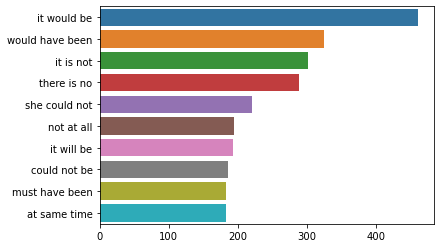

In [53]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter

def plot_top_ngrams_barchart(text, n=2):
    stop=['the', 'and', 'i', 'to', 'of', 'a', 'in', 'to', 'had', 'he',
             'that', 'you', 'was', 'with', 'form', 'his', 'as', 'odin', 'said', 'one']

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

plot_top_ngrams_barchart(train['text'], n=3)  

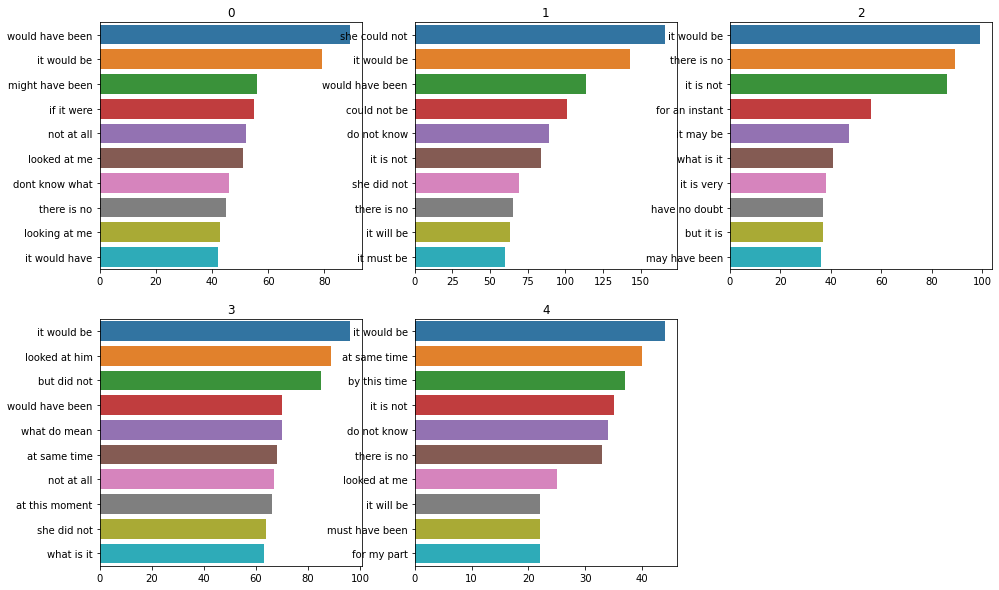

In [54]:
fig = plt.figure(figsize=(16,10)) # rows*cols 행렬의 i번째 subplot 생성
rows = 2
cols = 3

def plot_top_ngrams_barchart2(text, n=2):
    stop=['the', 'and', 'i', 'to', 'of', 'a', 'in', 'to', 'had', 'he', 'man',
             'that', 'you', 'was', 'with', 'form', 'his', 'as', 'odin', 'said', 'one']

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    
    return x, y

for i in range(5):
    x,y = plot_top_ngrams_barchart2(train[train['author']==i]['text'], n=3)
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(i)
    sns.barplot(x=y,y=x)

- wordcloud

In [65]:
from wordcloud import WordCloud, STOPWORDS
import nltk

nltk.download('stopwords')
stop=['the', 'and', 'i', 'to', 'of', 'a', 'in', 'to', 'had', 'he',
             'that', 'you', 'was', 'with', 'form', 'his', 'as', 'odin', 'said', 'one']

def plot_wordcloud(text):
    

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))
    
    return wordcloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\naeun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


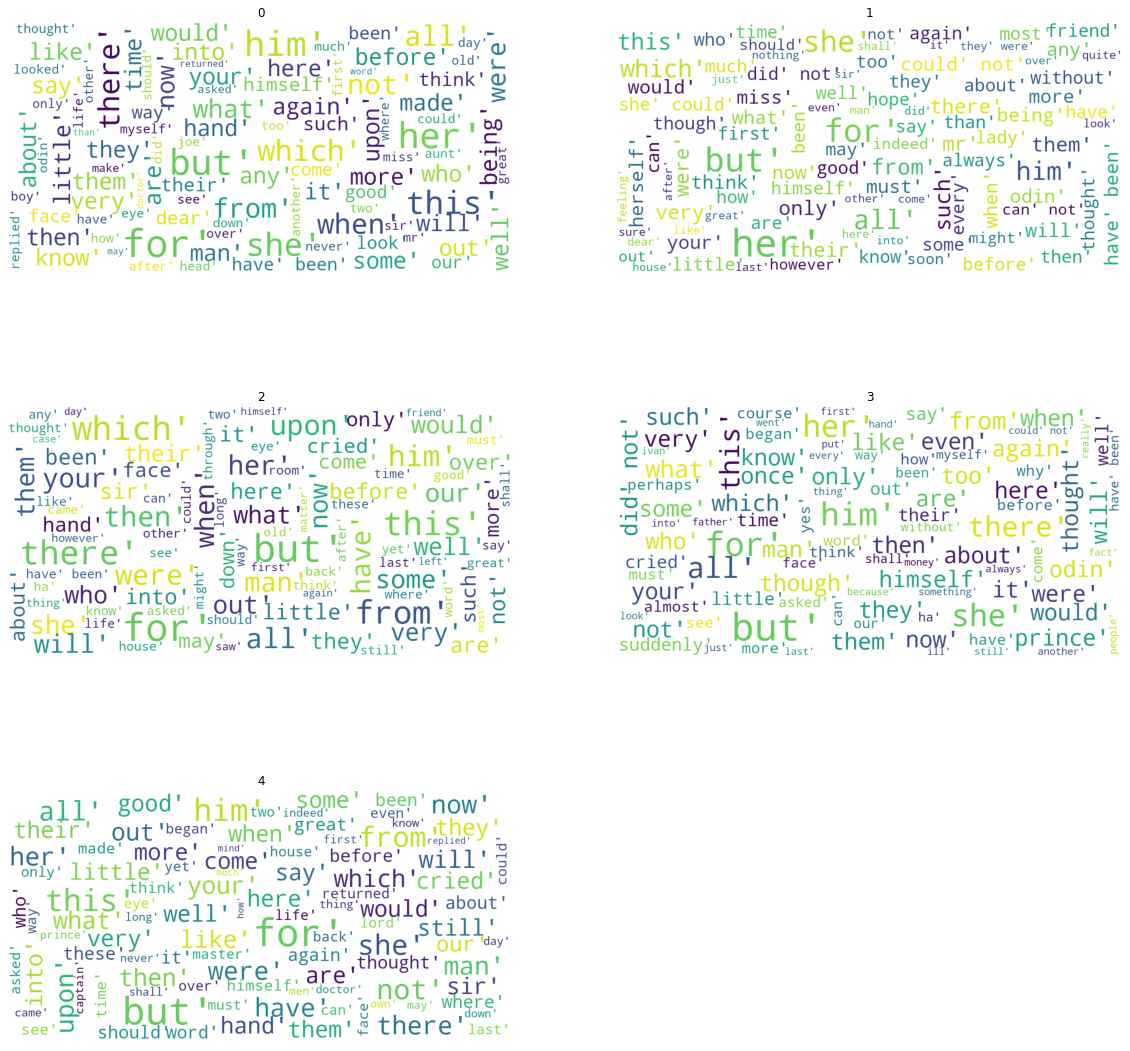

In [67]:
fig = plt.figure(figsize=(20,20)) # rows*cols 행렬의 i번째 subplot 생성
rows = 3
cols = 2

for i in range(5):
    wordcloud = plot_wordcloud(train[train['author']==i]['text'])
    ax = fig.add_subplot(rows, cols, i+1)
    
    #fig = plt.figure(1, figsize=(12, 12))
    ax.axis('off')
    ax.set_title(i)
    ax.imshow(wordcloud)
    #plt.show()

In [70]:
# 명사만 확인하기

import nltk
nltk.download('averaged_perceptron_tagger')

def plot_wordcloud_noun(text,tags=['NN','NNP']):
    

    def _preprocess_text(text,tags):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]
            words=[lem.lemmatize(w) for w in words if len(w)>2]
            
            tagged = nltk.pos_tag(words)
            allnoun = [word for word, pos in tagged if pos in tags]

            corpus.append(allnoun)
        return corpus
    
    corpus=_preprocess_text(text,tags)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))
    
    return wordcloud

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\naeun\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


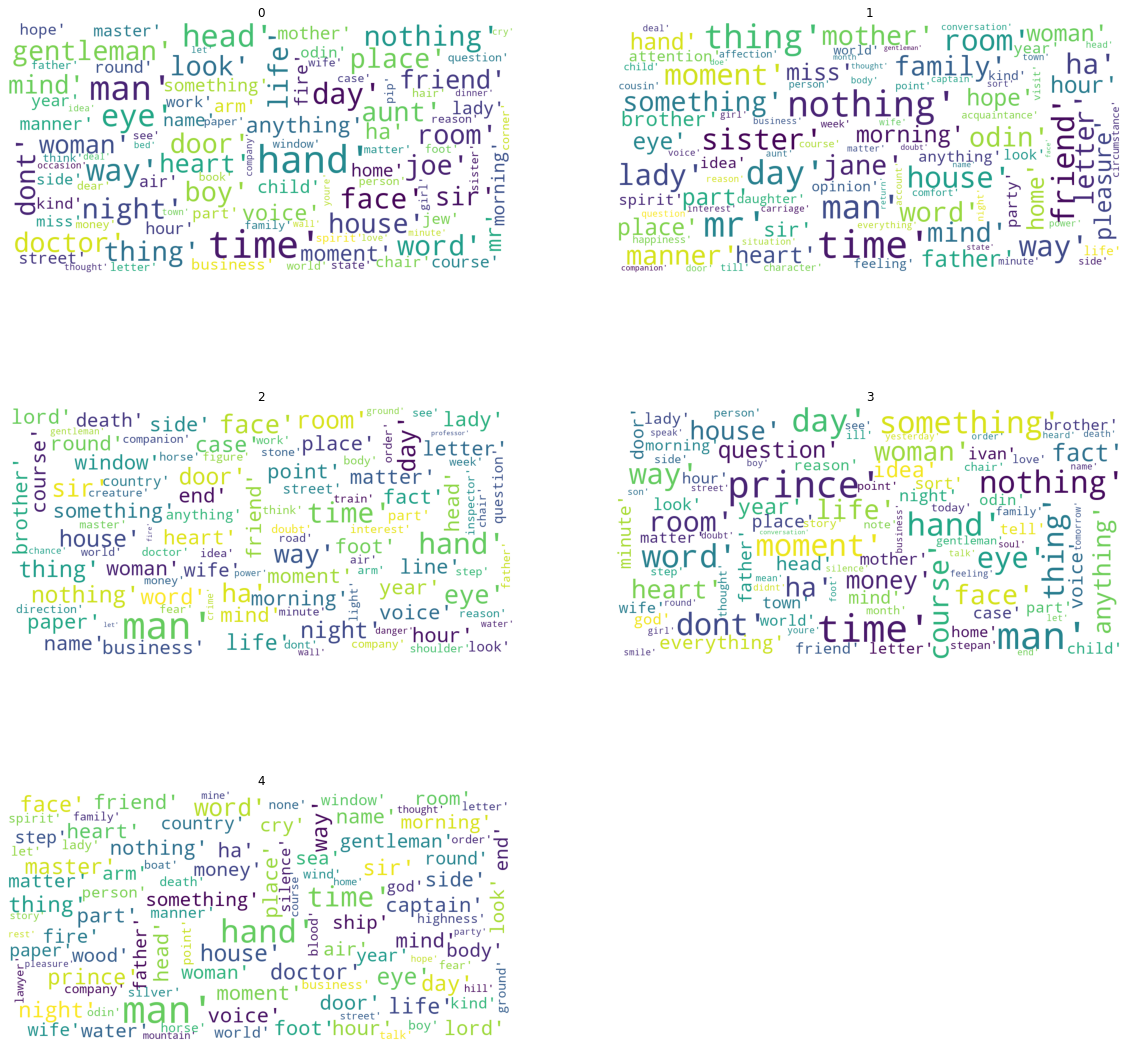

In [72]:
fig = plt.figure(figsize=(20,20)) # rows*cols 행렬의 i번째 subplot 생성
rows = 3
cols = 2

for i in range(5):
    wordcloud = plot_wordcloud_noun(train[train['author']==i]['text'], ['NN','NNP'])
    ax = fig.add_subplot(rows, cols, i+1)
    ax.axis('off')
    ax.set_title(i)
    ax.imshow(wordcloud)

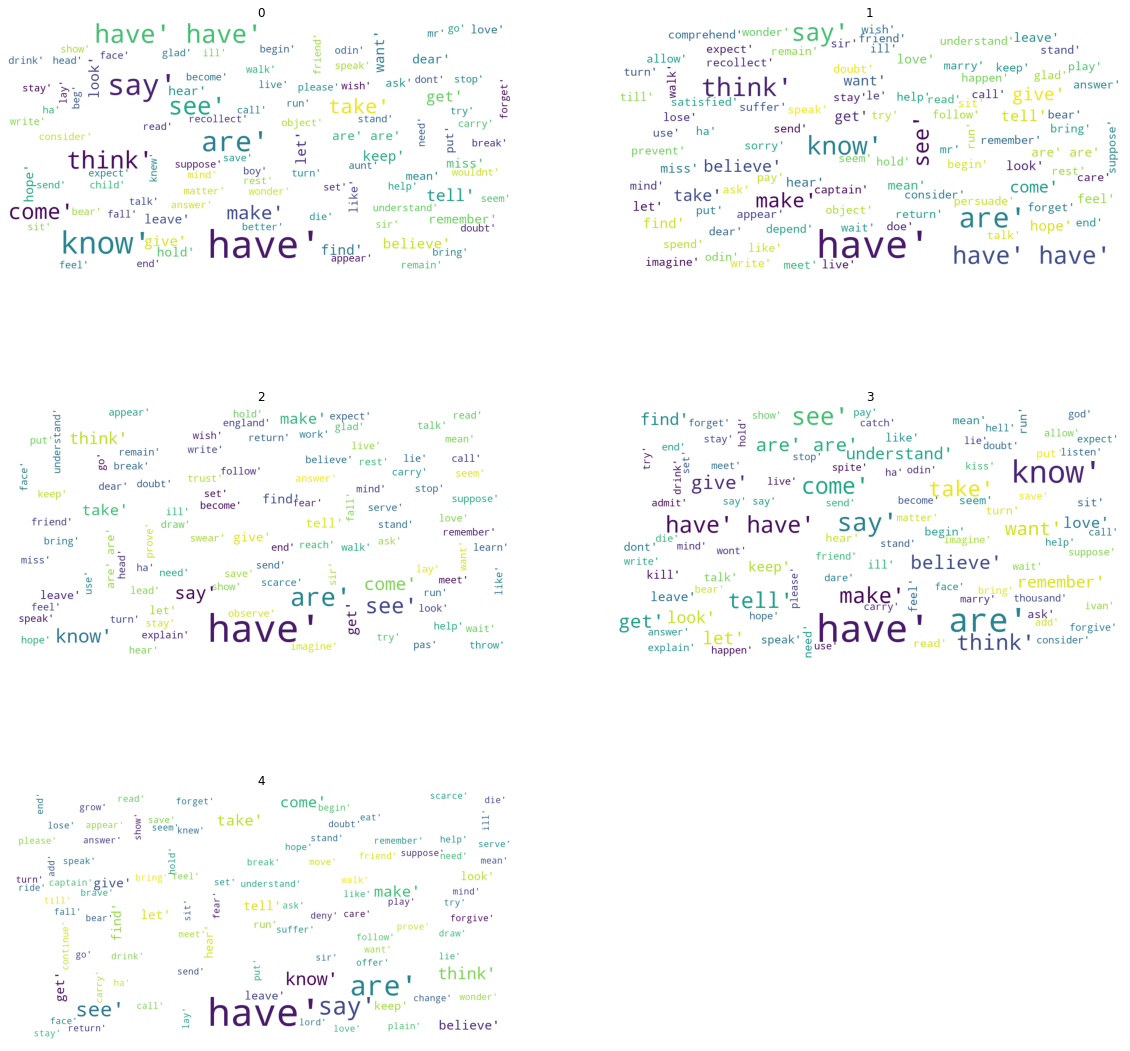

In [73]:
# 동사만 확인하기
fig = plt.figure(figsize=(20,20)) # rows*cols 행렬의 i번째 subplot 생성
rows = 3
cols = 2

for i in range(5):
    wordcloud = plot_wordcloud_noun(train[train['author']==i]['text'], ['VB','VBP'])
    ax = fig.add_subplot(rows, cols, i+1)
    ax.axis('off')
    ax.set_title(i)
    ax.imshow(wordcloud)

In [146]:
vec = CountVectorizer(tokenizer=word_tokenize, stop_words=['the', 'and', 'i', 'to', 'of', 'a', 'in', 'to', 'had', 'he', 'man', 'have', 'are',
             'that', 'you', 'was', 'with', 'form', 'his', 'as', 'odin', 'said', 'one'], ngram_range=(1, 2), min_df=100)
X_cnt = vec.fit_transform(train['text'])
print(X_cnt.shape)

(54879, 2426)


In [147]:
X_cnt[0, :50].todense()

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

In [167]:
vec = TfidfVectorizer(tokenizer=word_tokenize, stop_words=['the', 'and', 'i', 'to', 'of', 'a', 'in', 'to', 'had', 'he', 'man', 'have', 'are',
             'that', 'you', 'was', 'with', 'form', 'his', 'as', 'odin', 'said', 'one'], ngram_range=(1, 3), min_df=50)
X = vec.fit_transform(train['text'])
X_tst = vec.transform(test['text'])
print(X.shape, X_tst.shape)

(54879, 5121) (19617, 5121)


In [150]:
X[0, :50].todense()

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])

# 로지스틱회귀 모델 학습

In [152]:
target_col = 'author'
n_fold = 5
n_class = 5
seed = 42

cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [154]:
y = train.author.values
y.shape

(54879,)

In [168]:
X_tst.shape

(19617, 5121)

In [164]:
X1 = X.reshape(-1, 1)

In [165]:
X.shape

(281035359, 1)

In [171]:
p = np.zeros((X.shape[0], n_class))
p_tst = np.zeros((X_tst.shape[0], n_class))
for i_cv, (i_trn, i_val) in enumerate(cv.split(X, y), 1):
    clf = LogisticRegression()
    clf.fit(X[i_trn], y[i_trn])
    p[i_val, :] = clf.predict_proba(X[i_val])
    p_tst += clf.predict_proba(X_tst) / n_class

In [172]:
print(f'Accuracy (CV): {accuracy_score(y, np.argmax(p, axis=1)) * 100:8.4f}%')
print(f'Log Loss (CV): {log_loss(pd.get_dummies(y), p):8.4f}')

Accuracy (CV):  69.4710%
Log Loss (CV):   0.8421


# 잠깐!

In [89]:
#파라미터 설정
vocab_size = 20000
embedding_dim = 16
max_length = 500
padding_type='post'
#oov_tok = "<OOV>"

In [90]:
#tokenizer에 fit
tokenizer = Tokenizer(num_words = vocab_size) # oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [91]:
#데이터를 sequence로 변환 후 padding
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)

In [122]:
#가벼운 NLP모델 생성
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [123]:
# compile model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 16)           320000    
_________________________________________________________________
global_average_pooling1d_3 ( (None, 16)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 125       
Total params: 320,533
Trainable params: 320,533
Non-trainable params: 0
_________________________________________________________________
None


In [131]:
# fit model
num_epochs = 20
history = model.fit(train_padded, y_train, 
                    epochs=num_epochs, verbose=2, 
                    validation_split=0.2)

Epoch 1/25
1372/1372 - 10s - loss: 0.4207 - accuracy: 0.8480 - val_loss: 0.7414 - val_accuracy: 0.7392
Epoch 2/25
1372/1372 - 10s - loss: 0.4064 - accuracy: 0.8534 - val_loss: 0.7317 - val_accuracy: 0.7406
Epoch 3/25
1372/1372 - 9s - loss: 0.3970 - accuracy: 0.8567 - val_loss: 0.7785 - val_accuracy: 0.7343
Epoch 4/25
1372/1372 - 9s - loss: 0.3873 - accuracy: 0.8614 - val_loss: 0.7400 - val_accuracy: 0.7386
Epoch 5/25
1372/1372 - 8s - loss: 0.3734 - accuracy: 0.8670 - val_loss: 0.7518 - val_accuracy: 0.7401
Epoch 6/25
1372/1372 - 7s - loss: 0.3648 - accuracy: 0.8681 - val_loss: 0.7586 - val_accuracy: 0.7351
Epoch 7/25
1372/1372 - 8s - loss: 0.3579 - accuracy: 0.8710 - val_loss: 0.8109 - val_accuracy: 0.7248
Epoch 8/25
1372/1372 - 8s - loss: 0.3472 - accuracy: 0.8746 - val_loss: 0.7850 - val_accuracy: 0.7305
Epoch 9/25
1372/1372 - 8s - loss: 0.3404 - accuracy: 0.8765 - val_loss: 0.8105 - val_accuracy: 0.7291
Epoch 10/25
1372/1372 - 8s - loss: 0.3370 - accuracy: 0.8765 - val_loss: 0.7923 

In [132]:
mse = model.evaluate(train_padded, y_train, batch_size=1)

54879/54879 [==============================] - 65s 1ms/step - loss: 0.4090 - accuracy: 0.8657


In [138]:
# predict values
pred = model.predict_proba(test_padded)

In [139]:
pred.shape

(19617, 5)

In [140]:
pred

array([[5.2138041e-08, 8.9000392e-01, 1.0981134e-01, 1.8381469e-04,
        8.6684850e-07],
       [5.8167383e-02, 1.1110492e-02, 6.8909745e-03, 8.3775312e-01,
        8.6077988e-02],
       [9.9999702e-01, 2.9704863e-06, 1.3950871e-12, 5.4254851e-12,
        1.5793814e-09],
       ...,
       [1.3833088e-07, 9.9999988e-01, 6.9454685e-11, 4.2234098e-12,
        1.0926436e-15],
       [5.0537478e-06, 9.9999499e-01, 4.5458727e-08, 3.2628075e-10,
        9.5469223e-11],
       [9.9984360e-01, 2.8132637e-12, 6.7732217e-12, 1.5558962e-04,
        7.9021441e-07]], dtype=float32)

In [141]:
len(pred)

19617

In [142]:
sample_submission[['0','1','2','3','4']] = pred

In [143]:
sample_submission.to_csv('submission_25.csv', index = False, encoding = 'utf-8')